In [54]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate
import numpy as np

def normalize_vector(state_vector):
    """Normalize the input state vector."""
    norm = np.linalg.norm(state_vector)
    if norm < 1e-10:
        raise ValueError("Input vector cannot be zero.")
    return state_vector / norm

def recursively_amplitude_encoding(qc, qr, amplitudes, depth=0, controls=None):
    """Recursively encode amplitudes using RY and multi-controlled RY gates.
    
    Args:
        qc: quantum circuit to modify
        qr: qubits
        amplitudes: list of 2^n real numbers
        depth: qubit travese depth total n
        controls: list of control qubits at the current depth.
    
    
    """
    if len(amplitudes) <= 1:
        return

    if controls is None:
        controls = []

    mid = len(amplitudes) // 2
    left = amplitudes[:mid]
    right = amplitudes[mid:]

    norm_left = np.linalg.norm(left)
    norm_right = np.linalg.norm(right)
    norm_total = np.linalg.norm(amplitudes)

    if norm_total < 1e-14:
        return

    ratio = norm_left / norm_total
    if ratio > 1:
        ratio = 1
    angle = 2 * np.arccos(ratio)

    qubit_index =len(qr)-1- depth  # LSB to MSB
    control_labels = [f'q_{qr.index(q)}' for q in controls]
    
    #Apply controlled rotation
    if controls:
        cry_gate = RYGate(angle).control(len(controls))
        qc.append(cry_gate, controls + [qr[qubit_index]])
    else:
        qc.ry(angle, qr[qubit_index])

    if len(amplitudes) == 2:
        return  # Terminal case: no further recursion needed

    if norm_right > 1e-14:
        qc.barrier()
        qc.x(qr[qubit_index])
        #recursively encode the left amplitude with the current qubit as additional control
        recursive_amplitude_encoding(qc, qr, left / norm_left, depth + 1, controls + [qr[qubit_index]])
        qc.x(qr[qubit_index])
        qc.barrier()

    if norm_left > 1e-14 and depth + 1 < len(qr):
        #recursively encode the right amplitudes
        recursive_amplitude_encoding(qc, qr, right / norm_right, depth + 1, controls + [qr[qubit_index]])


In [56]:
def apply_phases_iteratively(qc, qr, complex_amplitudes):
    """
    Modifies an n-qubit circuit to apply phases from complex numbers.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to modify
        qr (QuantumRegister): The quantum register containing the qubits
        complex_amplitudes (list): List of 2^n complex numbers
    
    """
    # Validate input
    n_qubits = len(qr)
    expected_length = 2**n_qubits
    if len(complex_amplitudes) != expected_length:
        raise ValueError(f"Complex amplitudes array must have length {expected_length}, got {len(complex_amplitudes)}")
    
    
    # Extract phases from complex numbers
    phases = [np.angle(amp) for amp in complex_amplitudes]
    
    # Apply phases using multi-controlled phase gates
    for k in range(expected_length):
        if abs(phases[k]) > 1e-8:  # Only apply gate if phase is non-zero
            # Convert k to binary for control states, reversing for Qiskit ordering
            binary = format(k, f'0{n_qubits}b')[::-1]  
            control_states = [int(bit) for bit in binary]
            
            qc.barrier()
            # Apply X gates where control should be |0>
            for qubit, bit in enumerate(control_states):
                if bit == 0:
                    qc.x(qr[qubit])
            
            # Apply multi-controlled phase gate
            if n_qubits > 1:
                qc.mcp(phases[k], qr[:-1], qr[-1])
            else:
                # For 1 qubit, use single-qubit phase gate
                qc.p(phases[k], qr[0])
            
            # Undo X gates
            for qubit, bit in enumerate(control_states):
                if bit == 0:
                    qc.x(qr[qubit])
                    
            qc.barrier()

In [58]:
def prepare_quantum_state(amplitudes):
    """Prepare a quantum state with amplitude encoding for complex amplitudes.
    
    Args:
        amplitudes: a list of 2^n complex numbers. 
    
    """
    amplitudes = normalize_vector(amplitudes)
    n_qubits = int(np.log2(len(amplitudes)))
    if len(amplitudes) != 2**n_qubits:
        raise ValueError("Length of amplitudes must be 2^n")

    qr = QuantumRegister(n_qubits, 'q')
    qc = QuantumCircuit(qr)
    
    #adjust the magnitudes of the amplitudes
    magnitudes = np.abs(amplitudes)
    recursively_amplitude_encoding(qc, qr, magnitudes)
    
    #adjust the phase of the amplitudes
    apply_phases_iteratively(qc, qr, amplitudes)
    return qc

In [78]:
# Test
if __name__ == "__main__":
    test_cases = [
        np.array([1+1j, 2-1j, 3, 4]) / np.sqrt(32), # Test Case 1: n=2
        np.array([3+2j, 1j, 1+3j, -1j, -1, -1, -1+5j, 2j])/np.sqrt(57) ,       
        # Test Case 2: n=3
    ]

    for i, amplitudes in enumerate(test_cases):
        try:
            print(f"\nRunning Test Case {i+1}")
            print("Target state:", amplitudes)

            #prepare the quantum state circuit
            qc = prepare_quantum_state(amplitudes)
            
            #calculate statevector from the circuit
            sv = Statevector.from_instruction(qc)
            # fidelity = |<psi_target|psi_prepared>|^2
            fidelity = np.abs(np.vdot(amplitudes, sv.data))**2

            print("Prepared state:", sv.data)
            print(f"Fidelity: {fidelity:.10f}")

            print("Quantum Circuit:")
            print(qc.draw())
            
        except Exception as e:
            print(f"Error in Test Case {i+1}: {e}")


Running Test Case 1
Target state: [0.1767767 +0.1767767j 0.35355339-0.1767767j 0.53033009+0.j
 0.70710678+0.j       ]
Prepared state: [0.1767767 +0.1767767j 0.35355339-0.1767767j 0.53033009+0.j
 0.70710678+0.j       ]
Fidelity: 1.0000000000
Quantum Circuit:
                    ░      ┌────────────┐      ░ ┌────────────┐ ░ ┌───┐»
q_0: ───────────────░──────┤ Ry(2.0137) ├──────░─┤ Ry(1.8546) ├─░─┤ X ├»
     ┌────────────┐ ░ ┌───┐└─────┬──────┘┌───┐ ░ └─────┬──────┘ ░ ├───┤»
q_1: ┤ Ry(2.1682) ├─░─┤ X ├──────■───────┤ X ├─░───────■────────░─┤ X ├»
     └────────────┘ ░ └───┘              └───┘ ░                ░ └───┘»
«              ┌───┐ ░  ░                          ░ 
«q_0: ─■───────┤ X ├─░──░───────■──────────────────░─
«      │P(π/4) ├───┤ ░  ░ ┌───┐ │P(-0.46365) ┌───┐ ░ 
«q_1: ─■───────┤ X ├─░──░─┤ X ├─■────────────┤ X ├─░─
«              └───┘ ░  ░ └───┘              └───┘ ░ 

Running Test Case 2
Target state: [ 0.39735971+0.26490647j  0.        +0.13245324j  0.13245324+0.39735971

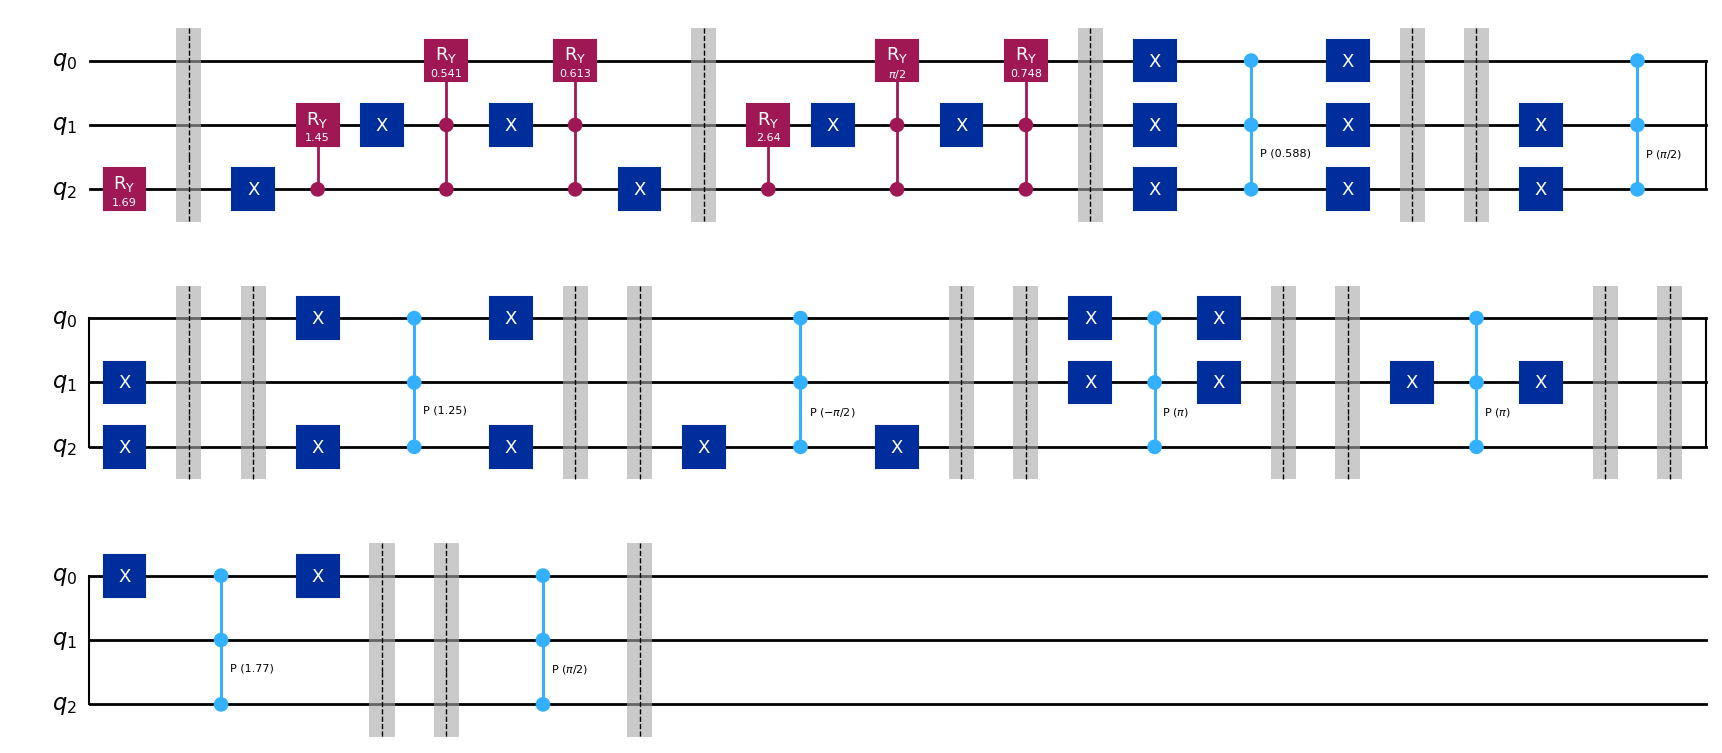

In [80]:
qc.draw(output="mpl")

In [82]:
psi = Statevector(qc)
psi.draw("Latex")

<IPython.core.display.Latex object>